# Problem 1: Chessboard Camera Extrinsics

### Objective 
Compute the position of a camera relative to a known marker arrangement. 

- In this case, the markers will be the corners of the squares on a checkerboard with known dimensions. 
- Learn how cameras can be used for localization against features, 
- Learn how projection to and from the image plane into world coordinates works

### env setup for p1_extrinsics.ipynb

```bash
$ uv venv
$ source .venv/bin/activate
$ uv pip install -r requirements.txt
$ uv pip install ipykernel
```

### Camera Extrinsics

The position $t \in R^3$ and orientation $R ∈ SO(3)$ of a camera with respect to some 
“world” frame are often jointly referred to as the camera `extrinsic parameters`, or `extrinsics` for short. 

Once obtained, the **extrinsics** can be used to transform a 3D point in the world frame $P ∈ R^3$ into a 3D point in
the camera frame $P^{\prime} ∈ R^3$ as follows:

$$P^{\prime} = RP + t$$

- $R$ and $t$ actually represent the position and orientation of the world frame with respect to the camera frame. 

The goal of this problem is to compute $R$ and $t$ of a camera for a world frame that lies on the surface of a chessboard.

### Chessboard 

Everything in this problem starts with a single image of a checkerboard. 

- Run through the first few cells in the notebook to see the image, p1_data/checkerboard.png,  we are working with for this problem
- We use a checkerboard because we can easily physically measure the side-lengths of the squares 
- For our problem the squares have a dimension of 0.0205m

The black and white pattern of the checkerboard has high contrast and it makes it easy to find the features that we are going to
use for calibration, square “cross-junctions”

<img src="i/f1.png" width=600>

### Feature Extraction

The first step towards computing the pose of the camera relative to the checkerboard is accurately estimating
the position of the cross-junctions in the image frame. 

- That is, in the image of the checkerboard, which pixels correspond to the cross-junctions?
- Fortunately, this question was answered quite a while ago by researchers studying computer vision.
- Solution is to apply a series of transformations on the image that isolate the high-contrast regions of the squares on the board, and then to use the Harris Corner Detection Algorithm to detect the cross-junctions.
- This combination of methods is provided in the cv2.findChessboardCorners(...) function


#### problem 1.1 

Use the `cv2.findChessboardCorners(...)` along with the corner parameters specified in the code to extract the cross-junction pixel locations, and plot them on top of the image using the ax.plot(...) function. 



K: 
 [[471.15  -4.95 295.13]
 [  0.   436.71 240.97]
 [  0.     0.     1.  ]]
u: [409.75568 373.57596 339.7811 ]
v: [337.2855  332.3364  326.45688]


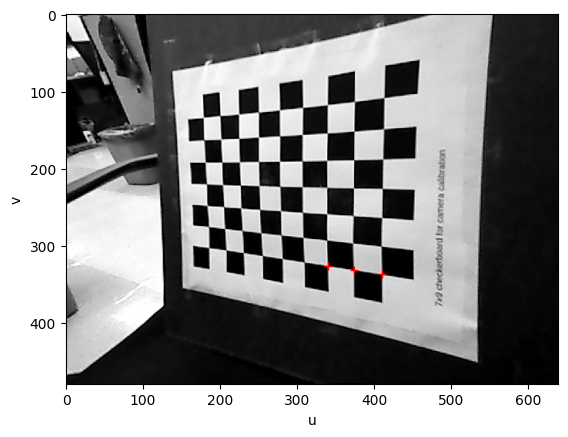

In [39]:
import numpy as np
from numpy.linalg import norm, inv, svd
import cv2
import matplotlib.pyplot as plt

np.random.seed(789) 

# The following utility functions are provided for your convenience.
# You may use them in your solution, or you may write your own.
# Do not alter them, and please read the docstrings carefully.
K = np.array([[471.14628085,  -4.94771211, 295.13159043], [0., 436.71106326, 240.96582594], [0., 0., 1.]])
SQUARE_SIZE = 0.0205
print(f"K: \n {np.round(K,2)}")

# Read the image from file
img_path = "p1_data/checkerboard.png"
image = cv2.imread(img_path, 0)

# Plot Corners on top of image
fig = plt.figure()
ax = plt.subplot()
ax.imshow(image, cmap="gray")
ax.set_ylabel("v")
ax.set_xlabel("u")

# 1) Find the corner locations of the chessboard in image space.
#    Hint: Use the function cv2.findChessboardCorners(image, (num_corners_x, num_corners_y))
#    Hint: findChessboardCorners outputs pixel coordinates!
# 2) Plot their location in image space over top of the image.
#    Hint: use ax.plot(...)
#    Hint: This should only be 1 line of code!

ncorners_y = 7
ncorners_x = 9

# --------- YOUR CODE STARTS HERE ---------------

ret, corners = cv2.findChessboardCorners(image, (ncorners_x, ncorners_y)) 
corners = corners.squeeze()

ax.plot(corners[0:3, 0], corners[0:3, 1], "r+")
# ax.plot(corners[0:-1, 0], corners[0:-1, 1], "r+")

# --------- YOUR CODE ENDS HERE -----------------
print(f"u: {corners[0:3, 0]}")
print(f"v: {corners[0:3, 1]}")

##### (ii) noisy and lower-resolution images
Q: If we were to use noisy and lower-resolution images, how would it impact corner detection?
A: It can reduce the accuracy of detected corners because the algorithm (Harris Detection) is built on con-
trastive thresholding within a small window around a pixel. 


Q: How can we get to ultimately enhance the results of camera calibration, and what techniques can we use?
A: Techniques to denoise, undistort images can help and the function to improve subpixel accuracy. 
- A direct function to use in OpenCV is cv2.cornerSubPix()


<img src="i/f2.png" width=800>

In this part of the problem we use a known camera intrinsics matrix $K$, the known distance between
cross-junctions $(0.0205 m)$, and the cross-junction image coordinates to compute 
the relative position and rotation of the camera to the chessboard

To solve for the position and rotation of the camera relative to the chessboard you will make use of a method
that is similar to the solution that was presented for the PnP problem discussed in Lecture 8. 

The main difference here is that all of the points exist on the surface of the chessboard, causing all of their z-components
to be zero in the world frame, see Figure 2. 

Inspecting the equation for transforming world coordinates into
homogeneous pixel coordinates we can see that this results in a slightly different set of equations:

<img src="i/f3.png" width=800>

##### (iii) compute the rotation $R$ and translation $t$
- Of the camera with respect to the chessboard in the image
- Use the method outlined above, and the corner locations from (i) 


In [42]:
# Problem 1.2
# 1)  Compute the homography, H.
#     1.a) Use the SQUARE_SIZE, and the dimensions of the grid above to
#             to create a the array P = [[X_0, Y_0, 1], .... [X_n, Y_n, 1]].
#             P should have shape (63, 3).
#          Hint: Use np.meshgrid to generate the X, Y coordinates, and
#             array.reshape and np.hstack to form the final matrix.
#     1.b) Form the M matrix outlined in the write-up!
#     1.c) Use np.linalg.svd(M) to solve for the nullspace of M and recover H.
#          Hint: np.linalg.svd(M) returns V.T.
#          Hint: Use <array>.reshape(3, 3) to give H the proper dimensions.

# 2)  Compute the camera pose rotation, R, and translation, t.
#     2.a) Compute KinvH = inv(K) @ H.
#          Hint: Use np.linalg.inv().
#     2.b) Normalize the values of KinvH to it's first column.
#          Hint: Use np.linalg.norm() and the / operator.
#     2.c) Compute r0, r1, r2, and t as outlined in the write-up.
#          Hint: Use np.cross().
#     2.d) Form R from r0, r1, and r2.
#          Hint: Use np.column_stack()

# --------- YOUR CODE STARTS HERE ---------------
xmeters = SQUARE_SIZE * np.arange(ncorners_x)
ymeters = SQUARE_SIZE * np.arange(ncorners_y)
X, Y = np.meshgrid(xmeters,ymeters)

X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))
ones = np.ones_like(X)

P = np.hstack((X, Y, ones))

M_u = np.hstack((-P, np.zeros_like(P), corners[:, 0].reshape(-1, 1) * P))
M_v = np.hstack((np.zeros_like(P), -P, corners[:, 1].reshape(-1, 1) * P))

M = np.vstack((M_u, M_v))

_, _, V = svd(M)
H = V[-1].reshape(3, 3)

KinvH = inv(K) @ H

# Normalize to the first column
KinvH = KinvH / norm(KinvH[:, 0]) 

r0 = KinvH[:, 0]
r1 = KinvH[:, 1]
r2 = np.cross(r0, r1)
t = KinvH[:, 2]

R = np.column_stack([r0, r1, r2])
print(f"t:\n{t}")
print(f"R:\n{R}")
# --------- YOUR CODE ENDS HERE -----------------

t:
[0.06041666 0.05504642 0.24836523]
R:
[[-0.84159518 -0.02457411  0.55448957]
 [-0.04607233 -1.01948989 -0.12028731]
 [ 0.53814022 -0.12721435  0.85686559]]


## Problem 1.3

Text(0, 0.5, 'v')

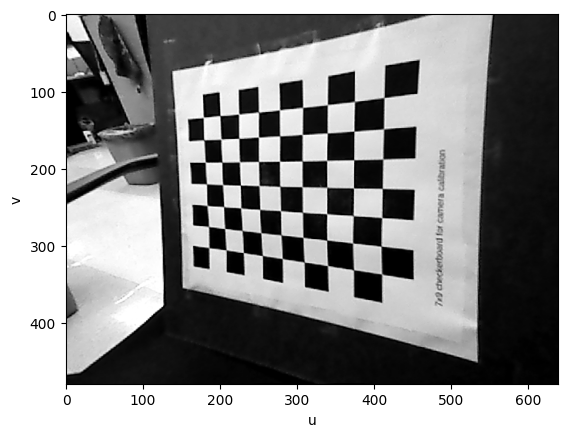

In [4]:
# 1) Finish the transform_world_to_camera function which uses
#       the given K, and the R and t that you calculated!.
#    Hint: You'll need to use some equations from the write-up.

def transform_world_to_camera(K, R, t, world_coords):
    """
    Args:
        K: np.array with shape (3, 3), camera intrinsics matrix.
        R: np.array with shape (3, 3), camera rotation.
        t: np.array with shape (3, ) or (3, 1), camera translation.
        world_coords: np.array with shape (N, 3), cartesian coordinates (X, Y, Z)
            in world frame to transform into camera pixel space.
    Return:
        uv: np.array with shape (N, 2), with (u, v) coordinates of that are
            the projections of the the world_coords on the image plane.
    """
    # --------- YOUR CODE STARTS HERE ---------------

    # --------- YOUR CODE ENDS HERE -----------------
    return uv

ax = plt.subplot()
ax.imshow(image, cmap="gray")
ax.set_xlabel("u")
ax.set_ylabel("v")

# 2) Project the global coordinates of the corners that you calculated
#       earlier back onto the image using transform_world_to_camera.
#    Hint: The input world_coords should have shape (63, 3)
#    Hint: Use the Xs and Ys you got earlier and set Zs = 0.
#    Hint: You may need to change some of the variable names at the bottom
#       of this cell to match the names that you used above!

# --------- YOUR CODE STARTS HERE ---------------

# --------- YOUR CODE ENDS HERE -----------------

## Project Anything!
Try using your the camera pose you computed to project our secret point cloud (defined in world coordinates) onto the camera frame!

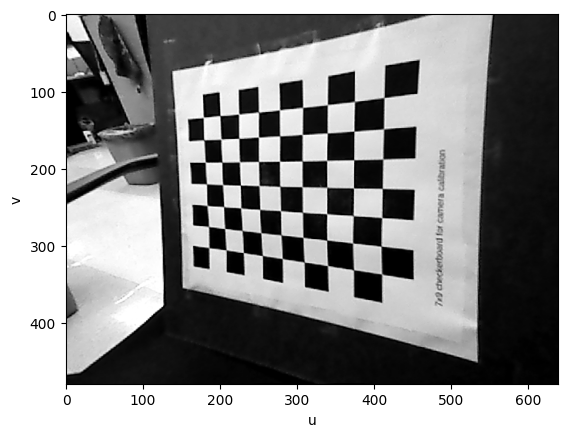

In [5]:
ax = plt.subplot()
ax.imshow(image, cmap="gray")
ax.set_xlabel("u")
ax.set_ylabel("v")

# Load the secrect point cloud from file!
point_cloud_secret = np.load("p1_data/secret.npy")

# NOTE: Uncomment the lines below when you've finished everything else!
# uv_secret = transform_world_to_camera(K, R, t, point_cloud_secret)
# ax.scatter(uv_secret[:, 0], uv_secret[:, 1], s=0.5, c="b")